In [ ]:
conda env export > environment.yml

In [1]:
import os
import re
import string
import unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [2]:
import inflect
from spellchecker import SpellChecker
import csv

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## import datasets

In [4]:
# import dataset
df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
#target = pd.read_csv('train.csv', usecols=['target'])

In [223]:
print(len(df))
print(len(test_df))

7503
3243


In [6]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
print(len(df))
print(len(test_df))

7503
3243


## visualize target data

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

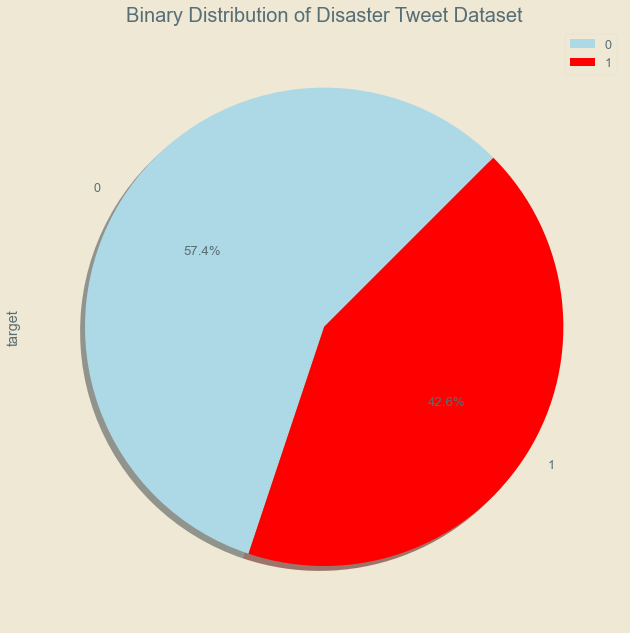

In [7]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

## dictionaries from file for abbreviation/contraction replacement

In [191]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [192]:
location_expansion_dict = csv2dict('location_expansion.csv')
contractions_dict = csv2dict('contractions.csv')

## denoise

def word_expansion(text, expansion_dict):
        c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text)
        return text
    
def camel_case_split(text):
    if text.startswith('#'):
    #function to expand hashtags containing camel case to words using capital letters as markers for split
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z+]|(?<!\A)(?=[A-Z])[a-z+])'+r'{1,}', r' \1', text)
    else:
        exp_hashtags = text
    return exp_hashtags

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*https?:\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@[^\s]+",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)
    
    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    text = remove_urls(text)
    text = remove_handles(text)
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = remove_non_alpha(text)
    return text      

In [259]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def pascal_case_split(text):
    if text[0]=="#" and text[1].isupper():
        text = re.sub('#', '', text)
        exp_ht = re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)
    else:
        exp_ht = text
    return exp_ht  

def camel_case_split(text):
    if text[0]=="#" and text[1].islower():
        text = re.sub('#', '', text)
        exp_ht = re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)
    else:
        exp_ht = text
    return exp_ht

def remove_hash(text):
    new_text = re.sub('#', '', text)
    return new_text
        
def expand_hashtags(text):
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    new_text = remove_hash(p_text)
    return new_text
    
    
# def expand_hashtags(text):
#     if text[0]=="#":
#         if text.isupper() or text.islower():
#             text = re.sub('#', '', text)
#             exp_ht = text
#             return exp_ht
#         if text[1].isupper():
#             text = re.sub('#', '', text)
#             exp_ht = re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)
#             return exp_ht
#         if text[1].islower():
#             text = re.sub('#', '', text)
#             exp_ht = re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)
#             return exp_ht
#     else:
#         exp_ht = text
#         return exp_ht   

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([({ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_vowels_mixed_case(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    uvowels = map(lambda x:x.upper(), [x for x in vowels])
    uv = list(uvowels)
    for ch in iter(vowels):
        text = re.sub(rf'([({ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uv):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants_mixed_case(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    uconsonants = map(lambda x:x.upper(), [x for x in consonants])
    uc = list(uconsonants)
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uc):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*https?:\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@[^\s]+",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)
    
    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    text = remove_urls(text)
    text = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', text)
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = remove_non_alpha(text)
    return text      

## tokenize 

def lemmatize_text_verbs(text):
    #function to tokenize and lemmatize text, and split text into tokens
    lemmatizer = WordNetLemmatizer()
    if text==text.title():
        word = lemmatizer.lemmatize(text, 'v').capitalize()
    if text==text.isupper():
        word = lemmatizer.lemmatize(text, 'v').upper()
    else:
        word = lemmatizer.lemmatize(text, 'v')
    return word

def lemmatize_text_nouns(text):
    #function to tokenize and lemmatize text, and split text into tokens
    lemmatizer = WordNetLemmatizer()
    if text==text.title():
        word = lemmatizer.lemmatize(text, 'n').capitalize()
    if text==text.isupper():
        word = lemmatizer.lemmatize(text, 'n').upper()
    else:
        word = lemmatizer.lemmatize(text, 'n')
    return word

In [260]:


def lemmatize_text(text):
    #function to tokenize and lemmatize text, removing twitter handles and reducing length of words ex. loool = lol
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, 'v') for w in text.split(' ')]
    return tokens


def replace_numbers(tokens):
    # function to replace digits in string with numbers spelled out as words ex 11 = eleven
    dig2word = inflect.engine()
    new_tokens = []
    for word in tokens:
        word = re.sub('(?<=\d),(?=\d)', '', word)
        if word.isdigit():
            new_word = dig2word.number_to_words(int(word))
            new_tokens.append(str(new_word))
        else:
            new_tokens.append(word)
    return new_tokens


def remove_non_ascii(tokens):
    # function to remove non unicode characters from tokenized text
    new_tokens = []
    for word in tokens:
        new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_tokens.append(new_token)
    return new_tokens

def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens

def norm_text(tokens):
    # function to normalize text by replacing digits with words and removing stopwords performed on tokenized text
    words = replace_numbers(tokens)
    new_words = remove_stopwords(words)
    return new_words

## tweet text process

In [261]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        camel_text = expand_hashtags(text)
        exp_loc_tweet = word_expansion_from_dict(camel_text, expansion_dict=location_expansion_dict)
        exp_text = word_expansion_from_dict(exp_loc_tweet.lower(), expansion_dict=contractions_dict)
        return exp_text

    def process_text(text):
        exp_text = expand_hashtags(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join(x for x in norm_text(lem_text) if len(x) > 2)
        return text

    
    new_df = [process_text(x) for x in df]

    return new_df 

## keyword text process

In [262]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [263]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_text(text):
        camel_text = expand_hashtags(text) 
        #loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(camel_text, location_expansion_dict)
        return exp_text
        
    def process_text(text):
        exp_text = expand_hashtags(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join([x for x in norm_text(lem_text)])
        return text
    
    new_df = [process_text(x) for x in df]
    return new_df 

## create column containing combined column text & tokens columns

In [272]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweets.apply(lambda row: row.split())
    df['combined_tokens'] = df.all_text.str.lower()
    df['tweet_tokens'] = df.tweets.str.lower()
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

# create new dataframe applying above processes

In [273]:
df['tweets'] = process_tweet(df.text)
test_df['tweets'] = process_tweet(test_df.text)
df['clean_keyword'] = process_keyword(df.keyword.astype(str))
test_df['clean_keyword'] = process_keyword(test_df.keyword.astype(str))
df['clean_location'] = process_location(df.location.astype(str))
test_df['clean_location'] = process_location(test_df.location.astype(str))

train_df = combine_columns(df)
test_df2 = combine_columns(test_df)

In [274]:
train_df

,target,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
id,,,,,,,
1,1,Our Deeds Reason earthquake May ALLAH Forgive,,,Our Deeds Reason earthquake May ALLAH Forgive,our deeds reason earthquake may allah forgive,our deeds reason earthquake may allah forgive
4,1,Forest fire near Ronge Sask Canada,,,Forest fire near Ronge Sask Canada,forest fire near ronge sask canada,forest fire near ronge sask canada
5,1,All residents ask shelter place notify officer...,,,All residents ask shelter place notify officer...,all residents ask shelter place notify officer...,all residents ask shelter place notify officer...
6,1,people receive wildfires evacuation order Cali...,,,people receive wildfires evacuation order Cali...,people receive wildfires evacuation order cali...,people receive wildfires evacuation order cali...
7,1,Just get send photo Ruby Alaska smoke wildfire...,,,Just get send photo Ruby Alaska smoke wildfire...,just get send photo ruby alaska smoke wildfire...,just get send photo ruby alaska smoke wildfire...
...,...,...,...,...,...,...,...
10863,1,World News Fallen powerlines link tram UPDATE ...,,,World News Fallen powerlines link tram UPDATE ...,world news fallen powerlines link tram update ...,world news fallen powerlines link tram update ...
10864,1,flip side Walmart bomb everyone evacuate stay ...,,,flip side Walmart bomb everyone evacuate stay ...,flip side walmart bomb everyone evacuate stay ...,flip side walmart bomb everyone evacuate stay ...
10866,1,Suicide bomber kill Saudi security site mosque...,,,Suicide bomber kill Saudi security site mosque...,suicide bomber kill saudi security site mosque...,suicide bomber kill saudi security site mosque...


In [275]:
train_df.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('train samples: ',len(train_df))
test_df2.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('test samples: ',len(test_df2))

train samples:  6868
test samples:  3084


In [276]:
test_df2.to_csv('test_update_nostopwords.csv')
train_df.to_csv('train_update_nostopwords.csv')

In [283]:
from collections import Counter
tweets = train_df.tweet_tokens
word_dict = Counter(train_df.tweets.sum())
word_dict

Counter({'O': 1915,
         'u': 10675,
         'r': 24007,
         ' ': 56356,
         'D': 1959,
         'e': 40701,
         'd': 11461,
         's': 20204,
         'R': 2213,
         'a': 29635,
         'o': 23233,
         'n': 20992,
         't': 22265,
         'h': 9978,
         'q': 367,
         'k': 5112,
         'M': 1948,
         'y': 6787,
         'A': 3109,
         'L': 1820,
         'H': 1872,
         'F': 1607,
         'g': 6781,
         'i': 23860,
         'v': 3976,
         'f': 4810,
         'S': 3470,
         'C': 2634,
         'l': 18560,
         'p': 7446,
         'c': 11472,
         'x': 974,
         'w': 5125,
         'J': 590,
         'b': 5339,
         'm': 9385,
         'U': 794,
         'T': 3600,
         'W': 1598,
         'I': 1808,
         'E': 2485,
         'N': 2076,
         'V': 603,
         'P': 1756,
         'G': 1246,
         'K': 679,
         'B': 1936,
         'Y': 760,
         'z': 755,
         'Z': 1

In [ ]:
len(word_dict)

In [ ]:
print(min(word_dict)[:100])